In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.nn.functional as F

import numpy as np


import matplotlib.pyplot as plt

from PIL import Image

import os
import glob


from MyDataLoader import ShuffleDataLoader
from FileReader import get_picture_tensors
from MyModels import SimpleCNN
from ModelEvaluation import eval_model


In [2]:
# data params
n_classes = 50
required_train_imgs = 10
required_test_imgs = 1

In [ ]:
# root_dir = "dataset_chat_downscale"
root_dir = "dataset_chat_downscale_no_background"
(train_images, val_images, test_images, 
 train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes=n_classes, 
                                                              required_train_imgs=required_train_imgs, 
                                                              required_test_imgs=required_test_imgs)

Chargement de dataset_chat_downscale_no_background\0001  ->  12/17 images
Chargement de dataset_chat_downscale_no_background\0002  ->  12/20 images
Chargement de dataset_chat_downscale_no_background\0003  ->  12/15 images
Chargement de dataset_chat_downscale_no_background\0004  ->  12/56 images
Chargement de dataset_chat_downscale_no_background\0005  ->  12/41 images
Chargement de dataset_chat_downscale_no_background\0006  ->  12/40 images
Chargement de dataset_chat_downscale_no_background\0007  ->  12/41 images
Chargement de dataset_chat_downscale_no_background\0008  ->  12/18 images
Chargement de dataset_chat_downscale_no_background\0009  ->  12/13 images
Chargement de dataset_chat_downscale_no_background\0010  ->  12/36 images
Chargement de dataset_chat_downscale_no_background\0011  ->  12/26 images
Chargement de dataset_chat_downscale_no_background\0012  ->  12/17 images
Chargement de dataset_chat_downscale_no_background\0014  ->  12/16 images
Chargement de dataset_chat_downscale_n

In [4]:
# params du modèle, essayer avec gridsearch (idéalement Randomized pour ne pas prendre énormément de temps), avec une bonne machine durant la nuit ou qqch
# faudrait idéalement logger les performances selon chaque combination de params pour s'amuser
# num_epochs = 6
num_epochs = 4
batch_size = 8
learning_rate = 1e-3


train_dataset = ShuffleDataLoader(train_images, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataset = ShuffleDataLoader(val_images, val_labels)


model = SimpleCNN(n_classes)
# model = SimpleCNN(n_classes, pretrained = False)
model.train()

criterion = nn.CrossEntropyLoss()
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(params, lr = learning_rate)

# Gossage sur les params potentiel
# momentum = 0.5
# weight_decay = 1e-5 
# criterion = nn.CrossEntropyLoss(reduction = 'sum')
# criterion = nn.CrossEntropyLoss(reduction = 'none')
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(params, lr = learning_rate, weight_decay = weight_decay)
# optimizer = optim.SGD(params, lr = learning_rate, momentum = momentum)   

accuracy_at_each_epoch = []
for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    accuracy_at_each_epoch.append(eval_model(model, val_dataset))
    
print('Training and evaluation finished.')

Accuracy on validation dataset: 58.00%
Accuracy on validation dataset: 86.00%
Accuracy on validation dataset: 94.00%
Accuracy on validation dataset: 94.00%
Training and evaluation finished.


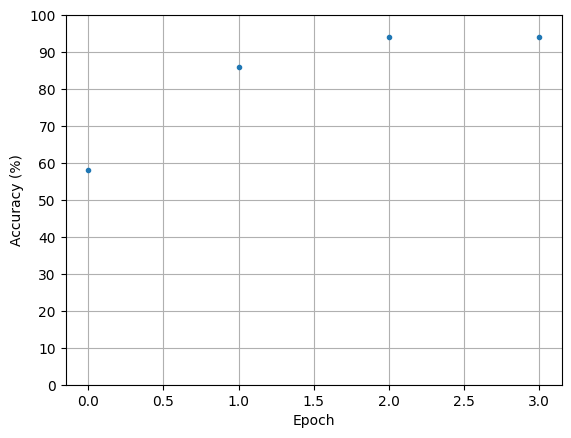

In [5]:
plt.plot(accuracy_at_each_epoch, '.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.yticks(np.arange(0, 110, 10))
plt.ylim(0, 100)
plt.grid(True)

In [6]:
# Pour loader des nouvelles données à tester
# Problème avec les labels!

# root_dir = "dataset_chat_downscale"
root_dir = "dataset_chat_downscale_no_background"
(train_images, val_images, test_images, 
 train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes=n_classes,
                                               required_train_imgs=required_test_imgs,
                                               required_test_imgs=required_test_imgs)

# array of 10 zeros
index = np.zeros(len(test_images))
score = np.zeros(len(test_images))
for i in range(len(test_images)-1, 0, -1):
    test_images = test_images[:i]  # sa réduit la taille jusqu'à 0.. 
    test_labels = test_labels[:i]
    test_dataset = ShuffleDataLoader(test_images, test_labels)
    # print(test_labels_i)
    index[i] = i
    score[i] = eval_model(model, test_dataset)

Chargement de dataset_chat_downscale_no_background\0001  ->  3/17 images
Chargement de dataset_chat_downscale_no_background\0002  ->  3/20 images
Chargement de dataset_chat_downscale_no_background\0003  ->  3/15 images
Chargement de dataset_chat_downscale_no_background\0004  ->  3/56 images
Chargement de dataset_chat_downscale_no_background\0005  ->  3/41 images
Chargement de dataset_chat_downscale_no_background\0006  ->  3/40 images
Chargement de dataset_chat_downscale_no_background\0007  ->  3/41 images
Chargement de dataset_chat_downscale_no_background\0008  ->  3/18 images
Chargement de dataset_chat_downscale_no_background\0009  ->  3/13 images
Chargement de dataset_chat_downscale_no_background\0010  ->  3/36 images
Chargement de dataset_chat_downscale_no_background\0011  ->  3/26 images
Chargement de dataset_chat_downscale_no_background\0012  ->  3/17 images
Chargement de dataset_chat_downscale_no_background\0014  ->  3/16 images
Chargement de dataset_chat_downscale_no_background\

Text(0, 0.5, 'Accuracy (%)')

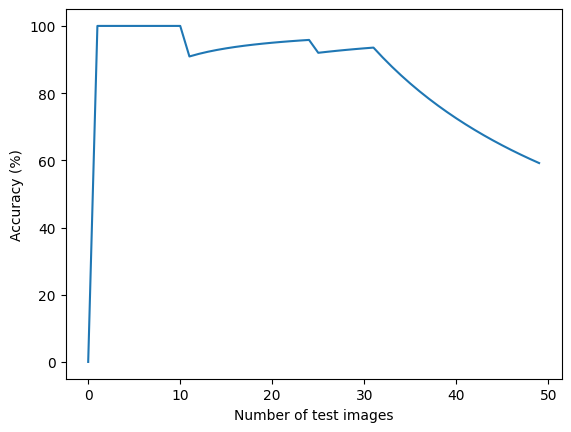

In [7]:
plt.plot(index, score)
plt.xlabel('Number of test images')
plt.ylabel('Accuracy (%)')

    Classe : 1
Prédiction : 1


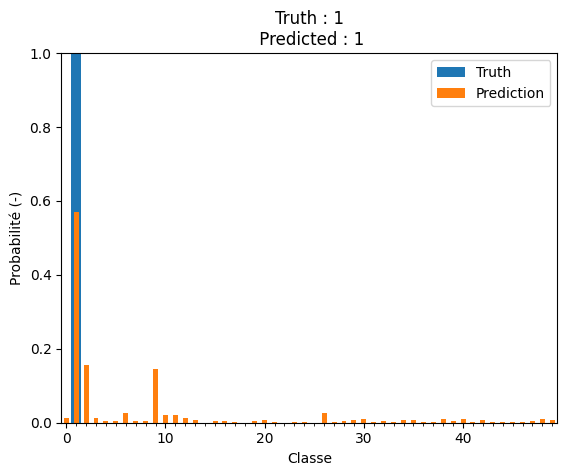

In [29]:
# Test individuel du model

import dataset_preprocessing

# root_dir = "dataset_chat_downscale"
root_dir = "dataset_chat_downscale_no_background"
(train_images, val_images, test_images, 
 train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes = n_classes,
                                               required_train_imgs = 1,
                                               required_test_imgs = 1,
                                               show_progress = False)

index = 1

# index 21 = 0023
# index 21 = 0026

# décommenter pour afficher l'image en tenseur
# Attention, sa cause problème avec le plt.plot() plus loin...
# dataset_preprocessing.show_images_as_grid(val_images[index])

model.eval()

with torch.no_grad():
    # images = train_images[index]
    # labels = train_labels[index]
    images = val_images[index]
    labels = val_labels[index]
    # images = test_images[index]
    # labels = test_labels[index]

    # print(labels)

    images = images.unsqueeze(0)
    outputs = model(images)
    # print(outputs)

    sig_output = F.sigmoid(outputs).squeeze(0)

    # print(sig_output)

    _, predicted = torch.max(outputs.data, 1)


x_axis = np.arange(0, n_classes, 1)




from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(1, 1)

ax.bar(x_axis, labels, width = 1, label = 'Truth')
ax.bar(x_axis, sig_output, width = 0.5, label = 'Prediction')
ax.set_xlabel('Classe')
ax.set_ylabel('Probabilité (-)')

ax.set_xlim(0 - 0.5, n_classes - 0.5)
ax.set_ylim(0, 1)

ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.legend(loc = 'best')

ax.set_title('Truth : ' + str(index) + '\n Predicted : ' + str(predicted.item()))




print('    Classe : ' + str(index))
print('Prédiction : ' + str(predicted.item()))
